## Summary

Firstly, human pose is extracted by a pretrained model.
Then some features are calculated based on the relative position of body parts, focus on these constrains:
- Hands are on belt
- One leg is straight
- Bend the other leg at the knee
- Body is straight

One simple heuristic model on these features can detect wether a pose is correct or not.

In [1]:
import os
import random
import math
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

In [2]:
# init pose detection library
mp_pose = mp.solutions.pose
mp_draw = mp.solutions.drawing_utils

## Plot some random images

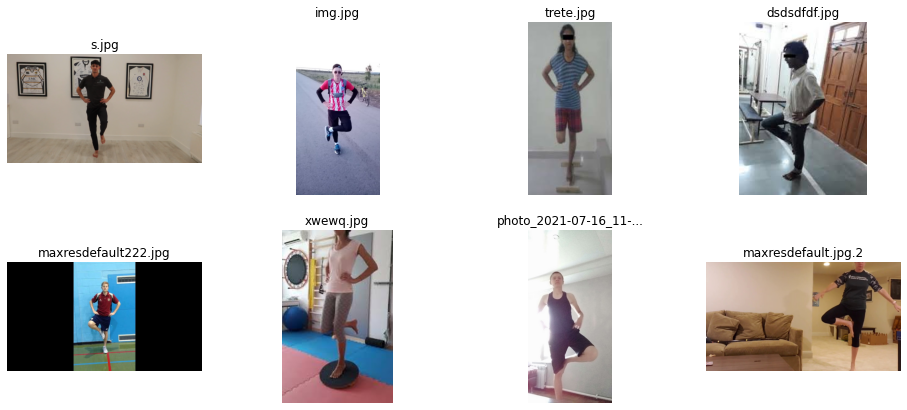

In [3]:
image_names = random.sample(os.listdir('data'), 8)

plt.rcParams['figure.figsize'] = (16, 7)

for num, image_name in enumerate(image_names):
    img = cv2.imread(os.path.join('data', image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, num+1)
    plt.title(image_name[:20] + '...' if len(image_name) > 20 else image_name)
    plt.axis('off')
    plt.imshow(img)

plt.show()

## Detect poses

In [4]:
def pose_to_points(img, pose):
    '''Extract coordinates of landmark points in images'''
    points = []
    if pose.pose_landmarks == None:
        return points
    for id, lm in enumerate(pose.pose_landmarks.landmark):
        h, w, c = img.shape
        cx, cy = int(lm.x*w), int(lm.y*h)
        points.append((cx, cy))
    return points

In [5]:
def draw_pose(img, pose):
    '''Add pose to image for visualization'''
    mp_draw.draw_landmarks(img, pose.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    points = pose_to_points(img, pose)
    for point in points:
        cv2.circle(img, point, 5, (255,0,0), cv2.FILLED)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


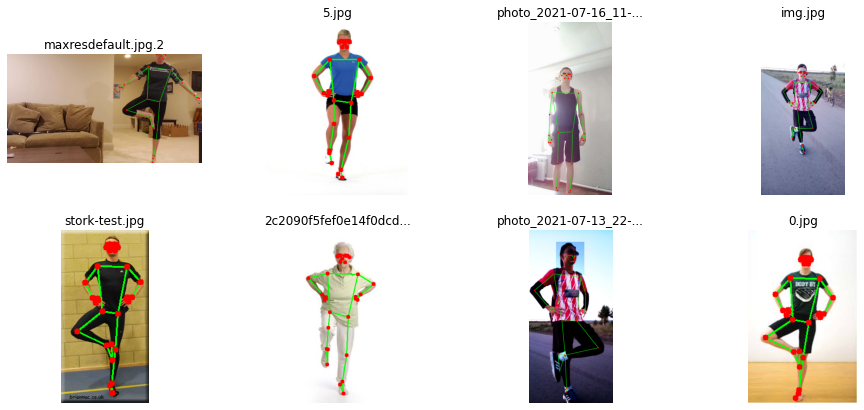

In [6]:
image_names = random.sample(os.listdir('data'), 8)

plt.rcParams['figure.figsize'] = (16, 7)

for num, image_name in enumerate(image_names):
    img = cv2.imread(os.path.join('data', image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mp_pose_detect = mp_pose.Pose()
    pose = mp_pose_detect.process(img)
    draw_pose(img, pose)
    plt.subplot(2, 4, num+1)
    plt.title(image_name[:20] + '...' if len(image_name) > 20 else image_name)
    plt.axis('off')
    plt.imshow(img)

plt.show()

## Extract features

In [7]:
def calculate_distance(x1, y1, x2, y2):
    '''Calculate distance between 2 points in 2D space'''
    return math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))

In [8]:
def calculate_angle(x1, y1, x2, y2, x3, y3):
    '''Calculate angel between 3 points in 2D space'''
    ux, uy = x2 - x1, y2 - y1
    vx, vy = x2 - x3, y2 - y3
    cos = (ux * vx + uy * vy) / (math.sqrt(ux*ux + uy*uy) * math.sqrt(vx*vx + vy*vy))
    return math.degrees(math.acos(cos))

In [9]:
def extract_features_from_pose(points):
    '''Extract features based on relative positions of body parts'''
    # Because the body size in images are different, we use the total length of the pose connection
    # path to normalize the distance between body parts.
    pose_connections_length = 0
    for con in mp_pose.POSE_CONNECTIONS:
        pose_connections_length += calculate_distance(points[con[0]][0], points[con[0]][1],
                                                      points[con[1]][0], points[con[1]][1])

    # Distance between left knee and right foot
    dist__left_knee__right_foot = calculate_distance(points[mp_pose.PoseLandmark.LEFT_KNEE][0],
                                                     points[mp_pose.PoseLandmark.LEFT_KNEE][1],
                                                     points[mp_pose.PoseLandmark.RIGHT_HEEL][0],
                                                     points[mp_pose.PoseLandmark.RIGHT_HEEL][1])
    norm_dist__left_knee__right_foot = dist__left_knee__right_foot / pose_connections_length

    # Distance between right knee and left foot
    dist__right_knee__left_foot = calculate_distance(points[mp_pose.PoseLandmark.RIGHT_KNEE][0],
                                                     points[mp_pose.PoseLandmark.RIGHT_KNEE][1],
                                                     points[mp_pose.PoseLandmark.LEFT_HEEL][0],
                                                     points[mp_pose.PoseLandmark.LEFT_HEEL][1])
    norm_dist__right_knee__left_foot = dist__right_knee__left_foot / pose_connections_length

    # Distance between left hip and left hand
    dist__left_hip__left_hand = calculate_distance(points[mp_pose.PoseLandmark.LEFT_HIP][0],
                                                    points[mp_pose.PoseLandmark.LEFT_HIP][1],
                                                    points[mp_pose.PoseLandmark.LEFT_PINKY][0],
                                                    points[mp_pose.PoseLandmark.LEFT_PINKY][1])
    norm_dist__left_hip__left_hand = dist__left_hip__left_hand / pose_connections_length

    # Distance between right hip and right hand
    dist__right_hip__right_hand = calculate_distance(points[mp_pose.PoseLandmark.RIGHT_HIP][0],
                                                     points[mp_pose.PoseLandmark.RIGHT_HIP][1],
                                                     points[mp_pose.PoseLandmark.RIGHT_PINKY][0],
                                                     points[mp_pose.PoseLandmark.RIGHT_PINKY][1])
    norm_dist__right_hip__right_hand = dist__right_hip__right_hand / pose_connections_length

    # Angle of left leg (to determine leg is straight or not)
    angle__left_thigh__left_calf = calculate_angle(points[mp_pose.PoseLandmark.LEFT_ANKLE][0],
                                                          points[mp_pose.PoseLandmark.LEFT_ANKLE][1],
                                                          points[mp_pose.PoseLandmark.LEFT_KNEE][0],
                                                          points[mp_pose.PoseLandmark.LEFT_KNEE][1],
                                                          points[mp_pose.PoseLandmark.LEFT_HIP][0],
                                                          points[mp_pose.PoseLandmark.LEFT_HIP][1])

    # Angle of right leg (to determine leg is straight or not)
    angle__right_thigh__right_calf = calculate_angle(points[mp_pose.PoseLandmark.RIGHT_ANKLE][0],
                                                     points[mp_pose.PoseLandmark.RIGHT_ANKLE][1],
                                                     points[mp_pose.PoseLandmark.RIGHT_KNEE][0],
                                                     points[mp_pose.PoseLandmark.RIGHT_KNEE][1],
                                                     points[mp_pose.PoseLandmark.RIGHT_HIP][0],
                                                     points[mp_pose.PoseLandmark.RIGHT_HIP][1])

    # Angle of left upper body and left lower body (to determine the body is straight or not)
    angle__left_upper__left_lower = calculate_angle(points[mp_pose.PoseLandmark.LEFT_ANKLE][0],
                                                    points[mp_pose.PoseLandmark.LEFT_ANKLE][1],
                                                    points[mp_pose.PoseLandmark.LEFT_HIP][0],
                                                    points[mp_pose.PoseLandmark.LEFT_HIP][1],
                                                    points[mp_pose.PoseLandmark.LEFT_SHOULDER][0],
                                                    points[mp_pose.PoseLandmark.LEFT_SHOULDER][1])

    # Angle of right upper body and right lower body (to determine the body is straight or not)
    angle__right_upper__right_lower = calculate_angle(points[mp_pose.PoseLandmark.RIGHT_ANKLE][0],
                                                      points[mp_pose.PoseLandmark.RIGHT_ANKLE][1],
                                                      points[mp_pose.PoseLandmark.RIGHT_HIP][0],
                                                      points[mp_pose.PoseLandmark.RIGHT_HIP][1],
                                                      points[mp_pose.PoseLandmark.RIGHT_SHOULDER][0],
                                                      points[mp_pose.PoseLandmark.RIGHT_SHOULDER][1])

    return {
        'norm_dist__left_knee__right_foot': norm_dist__left_knee__right_foot,
        'norm_dist__right_knee__left_foot': norm_dist__right_knee__left_foot,
        'norm_dist__left_hip__left_hand': norm_dist__left_hip__left_hand,
        'norm_dist__right_hip__right_hand': norm_dist__right_hip__right_hand,
        'angle__left_thigh__left_calf': angle__left_thigh__left_calf,
        'angle__right_thigh__right_calf': angle__right_thigh__right_calf,
        'angle__left_upper__left_lower': angle__left_upper__left_lower,
        'angle__right_upper__right_lower': angle__right_upper__right_lower}

## Recognize inaccurate poses by heuristic

In [12]:
def features_analysis(features):
    '''Determine which corrections are needed from features'''
    inaccurates = []
    
    if features['norm_dist__left_hip__left_hand'] > 0.05:
        inaccurates.append('Left hand is not on belt')

    if features['norm_dist__right_hip__right_hand'] > 0.05:
        inaccurates.append('Right hand is not on belt')

    if features['norm_dist__left_knee__right_foot'] < 0.03:
        if features['angle__left_thigh__left_calf'] < 170:
            inaccurates.append('Left leg is not straight')
        elif features['angle__left_upper__left_lower'] < 160:
            inaccurates.append('Body is not straight')
        
    elif features['norm_dist__right_knee__left_foot'] < 0.03:
        if features['angle__right_thigh__right_calf'] < 170:
            inaccurates.append('Right leg is not straight')
        elif features['angle__right_upper__right_lower'] < 160:
            inaccurates.append('Body is not straight')
            
    else:
        inaccurates.append('Not bending leg at knee')
        
    return inaccurates

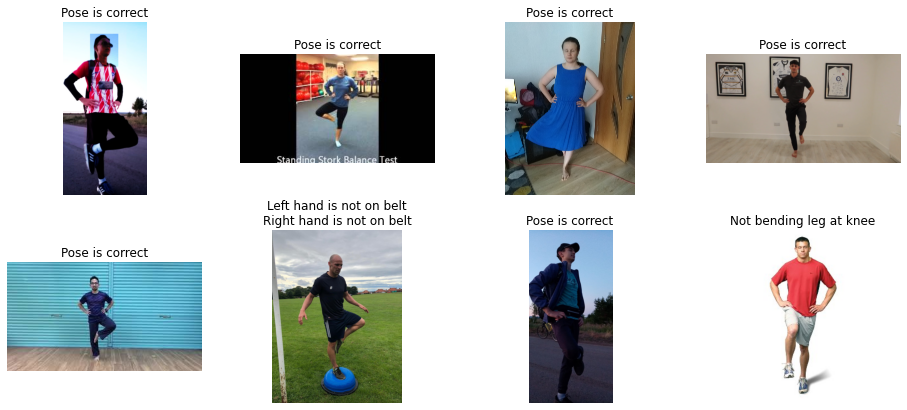

In [17]:
image_names = random.sample(os.listdir('data'), 8)

plt.rcParams['figure.figsize'] = (16, 7)

for num, image_name in enumerate(image_names):
    img = cv2.imread(os.path.join('data', image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mp_pose_detect = mp_pose.Pose()
    pose = mp_pose_detect.process(img)
    points = pose_to_points(img, pose)
    plt.subplot(2, 4, num+1)
    plt.axis('off')

    if len(points) > 0:
        features = extract_features_from_pose(points)
        inaccurates = features_analysis(features)
        if len(inaccurates) > 0:
            plt.title('\n'.join(inaccurates))
        else:
            plt.title('Pose is correct')
    else:
        plt.title('Can not detect pose')

    plt.imshow(img)

plt.show()